In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, AutoTokenizer
import torch
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
from sklearn.metrics import accuracy_score, f1_score, precision_recall_fscore_support, confusion_matrix
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import plotly.express as px
from sklearn.preprocessing import StandardScaler
import kagglehub
from datasets import Dataset, DatasetDict
import json
import seaborn as sns
from peft import get_peft_config, get_peft_model, LoraConfig, TaskType


/home/iza/Desktop/Studia/sem2/nlp/NLP_task1/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PEFT

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

path = kagglehub.dataset_download("waalbannyantudre/hate-speech-detection-curated-dataset")

print("Path to dataset files:", path)



Using device: cuda
Path to dataset files: /home/iza/.cache/kagglehub/datasets/waalbannyantudre/hate-speech-detection-curated-dataset/versions/1


In [3]:
import os

files = os.listdir(path)
print(files)

['HateSpeechDatasetBalanced.csv', 'HateSpeechDataset.csv']


In [4]:
# Specify the path to the CSV file
csv_file_path = os.path.join(path, 'HateSpeechDataset.csv') 

df = pd.read_csv(csv_file_path)
df['text'] = df['Content']
df = df.drop(columns=['Content_int', 'Content'])
df = df[df['Label'] != 'Label']


In [5]:
# Podział danych
texts_train, texts_test, text_labels_train, text_labels_test = train_test_split(
    df['text'], df['Label'], test_size=0.2, random_state=42
)

df_train = pd.DataFrame({'text': texts_train, 'LABEL': text_labels_train})
df_test = pd.DataFrame({'text': texts_test, 'LABEL': text_labels_test})

In [6]:
# Ustalanie minimalnej liczby klas
min_class_count_train = 500
min_class_count_test = 250

df_train_balanced = df_train.groupby('LABEL').apply(lambda x: x.sample(min_class_count_train)).reset_index(drop=True)
df_test_balanced = df_test.groupby('LABEL').apply(lambda x: x.sample(min_class_count_test)).reset_index(drop=True)

train_json = df_train_balanced.to_json(orient='records')
test_json = df_test_balanced.to_json(orient='records')

train_dataset = Dataset.from_list(json.loads(train_json))
test_dataset = Dataset.from_list(json.loads(test_json))

dataset = DatasetDict({
    'train': train_dataset,
    'test': test_dataset
})


/tmp/ipykernel_3885/27425786.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_train_balanced = df_train.groupby('LABEL').apply(lambda x: x.sample(min_class_count_train)).reset_index(drop=True)
/tmp/ipykernel_3885/27425786.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_test_balanced = df_test.groupby('LABEL').apply(lambda x: x.sample(min_class_count_test)).reset_index(drop=True)


In [7]:
# Mapowanie etykiet
sorted_labels = sorted(set(dataset['train']['LABEL']))
label2id = dict(zip(sorted_labels, range(len(sorted_labels))))
id2label = dict(zip(range(len(sorted_labels)), sorted_labels))

# Tokenizacja
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token  # Set pad_token to be the same as eos_token
model = GPT2ForSequenceClassification.from_pretrained("gpt2", num_labels=len(label2id), label2id=label2id, id2label=id2label)

# Funkcja preprocessing
def preprocess_function(examples):
    tokens = tokenizer(examples["text"], padding="max_length", truncation=True, return_tensors='pt')
    tokens['label'] = [label2id[l] for l in examples["LABEL"]]
    return tokens

# Tokenizacja zbiorów
tokenized_ds = {}
for split in ['train', 'test']:
    tokenized_ds[split] = dataset[split].map(preprocess_function, batched=True)

# Funkcja do obliczania metryk
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {"accuracy": (predictions == labels).mean() * 100, "f1": f1_score(labels, predictions, average='weighted')}




Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Map: 100%|██████████| 500/500 [00:00<00:00, 2270.39 examples/s]


In [8]:
tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = tokenizer.pad_token_id

In [9]:
# Konfiguracja Lora Adapter
peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,  # Sekwencja klasyfikacji
    inference_mode=False,       # Tryb treningowy
    r=8,                        # Stopień redukcji
    lora_alpha=1,              # Współczynnik skalowania Lora
    lora_dropout=0.1            # Dropout w adapterze
)

# Inicjalizacja adaptera w modelu
peft_model = get_peft_model(model, peft_config)
peft_model.print_trainable_parameters()


trainable params: 296,448 || all params: 124,737,792 || trainable%: 0.2377


/home/iza/Desktop/Studia/sem2/nlp/NLP_task1/.venv/lib/python3.10/site-packages/peft/tuners/lora/layer.py:1150: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


In [10]:
# Ustawienia trenera z PEFT
trainer = Trainer(
    model=peft_model,  # Używamy modelu z adapterem
    args=TrainingArguments(
        output_dir="gpt2-peft-classification",
        learning_rate=2e-3,
        per_device_train_batch_size=2,
        per_device_eval_batch_size=2,
        num_train_epochs=8,
        weight_decay=0.01,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
    ),
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["test"],
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics,
)

# Trening
trainer.train()


/home/iza/Desktop/Studia/sem2/nlp/NLP_task1/.venv/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
 12%|█▎        | 500/4000 [02:54<20:17,  2.87it/s]

{'loss': 0.9552, 'grad_norm': 50.00921630859375, 'learning_rate': 0.00175, 'epoch': 1.0}


                                                  
 12%|█▎        | 500/4000 [03:28<20:17,  2.87it/s]

{'eval_loss': 1.1403957605361938, 'eval_accuracy': 76.4, 'eval_f1': 0.7630293682925262, 'eval_runtime': 33.7912, 'eval_samples_per_second': 14.797, 'eval_steps_per_second': 7.398, 'epoch': 1.0}


 25%|██▌       | 1000/4000 [06:24<17:30,  2.86it/s]  

{'loss': 0.7987, 'grad_norm': 82.18893432617188, 'learning_rate': 0.0015, 'epoch': 2.0}


                                                   
 25%|██▌       | 1000/4000 [06:58<17:30,  2.86it/s]

{'eval_loss': 1.0148577690124512, 'eval_accuracy': 76.2, 'eval_f1': 0.754569341379609, 'eval_runtime': 33.9544, 'eval_samples_per_second': 14.726, 'eval_steps_per_second': 7.363, 'epoch': 2.0}


 38%|███▊      | 1500/4000 [09:53<14:30,  2.87it/s]  

{'loss': 0.7015, 'grad_norm': 0.03812852501869202, 'learning_rate': 0.00125, 'epoch': 3.0}


                                                   
 38%|███▊      | 1500/4000 [10:27<14:30,  2.87it/s]

{'eval_loss': 1.0218037366867065, 'eval_accuracy': 75.8, 'eval_f1': 0.7579525587015055, 'eval_runtime': 34.4797, 'eval_samples_per_second': 14.501, 'eval_steps_per_second': 7.251, 'epoch': 3.0}


 50%|█████     | 2000/4000 [13:25<11:41,  2.85it/s]  

{'loss': 0.5226, 'grad_norm': 0.6936489939689636, 'learning_rate': 0.001, 'epoch': 4.0}


                                                   
 50%|█████     | 2000/4000 [13:59<11:41,  2.85it/s]

{'eval_loss': 1.3666889667510986, 'eval_accuracy': 76.4, 'eval_f1': 0.7633601257801095, 'eval_runtime': 33.9833, 'eval_samples_per_second': 14.713, 'eval_steps_per_second': 7.357, 'epoch': 4.0}


 62%|██████▎   | 2500/4000 [16:57<08:48,  2.84it/s]  

{'loss': 0.4595, 'grad_norm': 1.2744492292404175, 'learning_rate': 0.00075, 'epoch': 5.0}


                                                   
 62%|██████▎   | 2500/4000 [17:31<08:48,  2.84it/s]

{'eval_loss': 1.170534372329712, 'eval_accuracy': 75.8, 'eval_f1': 0.7579757975797579, 'eval_runtime': 34.1136, 'eval_samples_per_second': 14.657, 'eval_steps_per_second': 7.328, 'epoch': 5.0}


 75%|███████▌  | 3000/4000 [20:29<05:54,  2.82it/s]  

{'loss': 0.3535, 'grad_norm': 0.0008584214374423027, 'learning_rate': 0.0005, 'epoch': 6.0}


                                                   
 75%|███████▌  | 3000/4000 [21:03<05:54,  2.82it/s]

{'eval_loss': 1.3415354490280151, 'eval_accuracy': 77.0, 'eval_f1': 0.7688674505074866, 'eval_runtime': 34.2056, 'eval_samples_per_second': 14.617, 'eval_steps_per_second': 7.309, 'epoch': 6.0}


 88%|████████▊ | 3500/4000 [24:02<02:57,  2.81it/s]  

{'loss': 0.2869, 'grad_norm': 0.02011183090507984, 'learning_rate': 0.00025, 'epoch': 7.0}


                                                   
 88%|████████▊ | 3500/4000 [24:36<02:57,  2.81it/s]

{'eval_loss': 1.5180917978286743, 'eval_accuracy': 76.8, 'eval_f1': 0.7679071628651462, 'eval_runtime': 34.4073, 'eval_samples_per_second': 14.532, 'eval_steps_per_second': 7.266, 'epoch': 7.0}


100%|██████████| 4000/4000 [27:34<00:00,  2.82it/s]  

{'loss': 0.2268, 'grad_norm': 0.055748648941516876, 'learning_rate': 0.0, 'epoch': 8.0}


                                                   
100%|██████████| 4000/4000 [28:09<00:00,  2.82it/s]

{'eval_loss': 1.5008183717727661, 'eval_accuracy': 76.8, 'eval_f1': 0.767996287940607, 'eval_runtime': 34.3019, 'eval_samples_per_second': 14.576, 'eval_steps_per_second': 7.288, 'epoch': 8.0}


100%|██████████| 4000/4000 [28:10<00:00,  2.37it/s]

{'train_runtime': 1690.4292, 'train_samples_per_second': 4.733, 'train_steps_per_second': 2.366, 'train_loss': 0.5380927467346192, 'epoch': 8.0}


TrainOutput(global_step=4000, training_loss=0.5380927467346192, metrics={'train_runtime': 1690.4292, 'train_samples_per_second': 4.733, 'train_steps_per_second': 2.366, 'total_flos': 4195319021568000.0, 'train_loss': 0.5380927467346192, 'epoch': 8.0})

In [11]:
# Zapis modelu z adapterem
peft_model.save_pretrained("gpt2_peft_model_weights")


In [12]:
# Predykcje
predictions = trainer.predict(tokenized_ds['test'])
predicted_labels = predictions.predictions.argmax(axis=1)
true_labels = predictions.label_ids
metrics = predictions.metrics

print("Wyniki:")
print("-" * 20)
for key, value in metrics.items():
    print(f"{key.replace('_', ' ').title()}: {value:.4f}" if isinstance(value, float) else f"{key.replace('_', ' ').title()}: {value}")


100%|██████████| 250/250 [00:34<00:00,  7.29it/s]

Wyniki:
--------------------
Test Loss: 1.0149
Test Accuracy: 76.2000
Test F1: 0.7546
Test Runtime: 34.4217
Test Samples Per Second: 14.5260
Test Steps Per Second: 7.2630


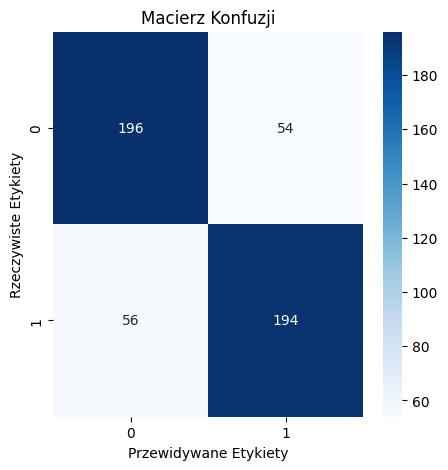

In [13]:
# Macierz konfuzji
conf_matrix = confusion_matrix(true_labels, predicted_labels)
labels = np.unique(true_labels)
confusion_df = pd.DataFrame(conf_matrix, index=labels, columns=labels)

plt.figure(figsize=(5, 5))
sns.heatmap(confusion_df, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=labels, yticklabels=labels)
plt.title('Macierz Konfuzji')
plt.xlabel('Przewidywane Etykiety')
plt.ylabel('Rzeczywiste Etykiety')
plt.show()

In [14]:
torch.cuda.empty_cache()


In [ ]:
# from torch.utils.data import DataLoader

# def get_embeddings_peft(examples):
#     # Tokenizacja danych
#     inputs = tokenizer(examples, padding="max_length", truncation=True, return_tensors='pt')    
#     inputs = {k: v.to('cpu') for k, v in inputs.items()}  # Przenieś dane na CPU

#     # Przenieś model na CPU
#     peft_model.to('cpu')  

#     with torch.no_grad():  # Wyłączamy gradienty dla oszczędności pamięci
#         outputs = peft_model(**inputs, output_hidden_states=True)
    
#     # Pobierz osadzenia dla CLS tokenu z ostatniej warstwy
#     token_embeddings = outputs.hidden_states[-1][:, 0, :].numpy()  # Już na CPU
#     return token_embeddings



# # Przygotowanie tekstów do wizualizacji
# text = pd.DataFrame(tokenized_ds['test']['text'], columns=['text'])

# # Opcjonalne dzielenie tekstu na wiersze dla czytelności
# def wrap_text(text, width=40):
#     return '<br>'.join([text[i:i+width] for i in range(0, len(text), width)])

# text['text'] = text['text'].apply(wrap_text)



# # Uzyskanie osadzeń za pomocą PEFT
# embeddings = get_embeddings_peft(dataset['test']['text'])

In [15]:
from torch.utils.data import DataLoader

def get_embeddings_peft_batch(examples, batch_size=8):
    # Use DataLoader to process in batches
    dataloader = DataLoader(examples, batch_size=batch_size, shuffle=False)
    all_embeddings = []

    for batch in dataloader:
        inputs = tokenizer(batch, padding="max_length", truncation=True, return_tensors='pt')
        inputs = {k: v.to('cuda') for k, v in inputs.items()}

        peft_model.to('cuda')

        with torch.no_grad():
            outputs = peft_model(**inputs, output_hidden_states=True)

        token_embeddings = outputs.hidden_states[-1][:, 0, :].cpu().numpy()
        all_embeddings.append(token_embeddings)

    # Combine all embeddings from the batch
    return np.concatenate(all_embeddings, axis=0)

# Example call:
embeddings = get_embeddings_peft_batch(dataset['test']['text'], batch_size=4)


In [18]:
# PCA - Redukcja wymiarów
pca = PCA(n_components=2).fit_transform(embeddings)

df_pca = pd.DataFrame(pca, columns=['PCA1', 'PCA2'])
df_pca['Predicted Label']  = [predicted_labels[i] for i in range(len(predicted_labels))]
df_pca['Text'] = dataset['test']['text']  # Assuming the text is here
df_pca['True label'] = [true_labels[i] for i in range(len(true_labels))]

fig = px.scatter(
    df_pca, 
    x="PCA1", 
    y="PCA2", 
    color="Predicted Label", 
    hover_data={'Text': True, 'True label': True}, 
    title="Wizualizacja przestrzeni wektorowej (PCA) dla PEFT",
    labels={"PCA1": "Pierwsza składowa główna", "PCA2": "Druga składowa główna"}
)
fig.show()


In [19]:
# TSNE - Wizualizacja nieliniowa
scaler = StandardScaler()
scaled_vectors = scaler.fit_transform(embeddings)

tsne = TSNE(n_components=2, random_state=42).fit_transform(scaled_vectors)

df_tsne = pd.DataFrame(tsne, columns=['x', 'y'])
df_tsne['Predicted Label']  = [predicted_labels[i] for i in range(len(predicted_labels))]
df_tsne['Text'] = dataset['test']['text']
df_tsne['True label'] = [true_labels[i] for i in range(len(true_labels))]

fig = px.scatter(
    df_tsne, 
    x='x', 
    y='y', 
    color='Predicted Label', 
    hover_data={'Text': True, 'True label': True}, 
    title="Wizualizacja TSNE dla PEFT",
)
fig.show()